In [2]:
import os
import librosa
import librosa.display
import IPython.display as ipd
from IPython.display import display
import numpy as np
import matplotlib.pyplot as plt
import math
from seaborn import heatmap
import seaborn as sns
from matplotlib import transforms
from skimage import metrics
import statistics
import copy

In [3]:
def importAudio(target, reference, output=True):
    if(output):
        display(ipd.Audio(target))
        display(ipd.Audio(reference))

    tArray, tSampleRate = librosa.load(target)
    rArray, rSampleRate = librosa.load(reference)

    tSTFT = librosa.stft(tArray, n_fft=frameSize, hop_length=hopSize)
    rSTFT = librosa.stft(rArray, n_fft=frameSize, hop_length=hopSize)

    tDFT = librosa.stft(tArray, n_fft=frameSize, hop_length=10000000000)
    rDFT = librosa.stft(rArray, n_fft=frameSize, hop_length=10000000000)
    
    return ({"STFT":tSTFT,"DFT":tDFT,"sampleRate":tSampleRate},{"STFT":rSTFT,"DFT":rDFT,"sampleRate":rSampleRate})

In [4]:
def exportAudio(tAudio, mAudio, rAudio):
    print("Target")
    tInverse = librosa.istft(tAudio["STFT"],n_fft=frameSize, hop_length=hopSize)
    display(ipd.Audio(tInverse, rate=tAudio["sampleRate"]))

    print("Matched")
    mInverse = librosa.istft(mAudio["STFT"],n_fft=frameSize, hop_length=hopSize)
    display(ipd.Audio(mInverse, rate=mAudio["sampleRate"]))

    print("Reference")
    rInverse = librosa.istft(rAudio["STFT"],n_fft=frameSize, hop_length=hopSize)
    display(ipd.Audio(rInverse, rate=rAudio["sampleRate"]))

In [5]:
def plotSpectrogram(tAudio, mAudio, rAudio):

    maximum = (max(np.max(np.abs(tAudio["STFT"])**2), np.max(np.abs(rAudio["STFT"])**2)))
    
    # derives the spectrogram from the STFT
    tSpectrogram = librosa.power_to_db(np.abs(tAudio["STFT"])**2, ref=np.max)
    mSpectrogram = librosa.power_to_db(np.abs(mAudio["STFT"])**2, ref=np.max)
    rSpectrogram = librosa.power_to_db(np.abs(rAudio["STFT"])**2, ref=np.max)

    # creates plots of spectrograms
    fig, ax = plt.subplots(nrows=3, ncols=1, sharex=True, figsize=(10*figScale, 5*figScale))
    tImg = librosa.display.specshow(tSpectrogram,sr=tAudio["sampleRate"],hop_length=hopSize,x_axis="time",y_axis="mel",cmap="magma",ax=ax[0])
    mImg = librosa.display.specshow(mSpectrogram,sr=mAudio["sampleRate"],hop_length=hopSize,x_axis="time",y_axis="mel",cmap="magma",ax=ax[1])
    rImg = librosa.display.specshow(rSpectrogram,sr=rAudio["sampleRate"],hop_length=hopSize,x_axis="time",y_axis="mel",cmap="magma",ax=ax[2])

    # adjusts appearance
    ax[0].set(title='Target')
    ax[1].set(title='Matched')
    ax[2].set(title='Reference')
    for ax_i in ax:
        ax_i.label_outer()
    fig.colorbar(mImg, ax=[ax[0], ax[1], ax[2]],format='%+2.0f dB')


<h3>Matching based on gain average of frequency bands</h3>

In [6]:
def plotCurve(tCurve,tCurveSmooth,rCurve,rCurveSmooth,mCurve):
    plt.figure(figsize=(10*figScale,5*figScale))

    plt.plot(20*np.log10(tCurve), alpha=0.2, color='blue', label="Target")
    plt.plot(20*np.log10(tCurveSmooth), color='blue', label="Convolved Target")

    plt.plot(20*np.log10(rCurve), alpha=0.2, color='red', label="Reference")
    plt.plot(20*np.log10(rCurveSmooth), color='red', label="Convolved Reference")

    plt.plot(20*np.log10(mCurve), color='green', label="Matched")
    
    plt.xlabel("Frequency Bin")
    plt.ylabel("Gain (dB)")
    plt.legend()

In [7]:
def convolve(curve, smoothing):
    curve = np.ravel(curve)
    kernel = np.ones(smoothing) / smoothing
    curve = np.convolve(curve, kernel, mode='same')
    curve = curve.reshape(len(curve),1)
    return curve

def EQMatching(tAudio, rAudio, smoothing=1, plot=True):
    tCurve = np.abs(tAudio["DFT"])
    tCurveSmooth = convolve(tCurve, smoothing)

    rCurve = np.abs(rAudio["DFT"])
    rCurveSmooth = convolve(rCurve, smoothing)

    scaler = rCurveSmooth / tCurveSmooth
    
    mSTFT = tAudio["STFT"] * scaler
    mDFT = tAudio["DFT"] * scaler
    mAudio = {"STFT":mSTFT,"DFT":mDFT,"sampleRate":tAudio["sampleRate"]}

    if(plot):
        mCurve = np.abs(mDFT)
        plotCurve(tCurve,tCurveSmooth,rCurve,rCurveSmooth,mCurve)
    
    return mAudio

In [8]:
# Plots a given frequency bin of target, matched, and reference audio, along with its dynamic response historgram
def plotDynamics(tAudio, rAudio, dynamicBins, plotBin, matched=False):
    # frequency bin
    tBin = np.abs(tAudio["STFT"][plotBin,:])
    rBin = np.abs(rAudio["STFT"][plotBin,:])

    # gets dynamic response historgram of target and reference
    tDynamicResponse, rDynamicResponse = getDynamicResponse(tAudio["STFT"][plotBin,:], rAudio["STFT"][plotBin,:], dynamicBins)

    bins = (tBin, rBin)
    dynamicResponse = (tDynamicResponse, rDynamicResponse)

    # plot
    fig, ax = plt.subplots(nrows=2, ncols=2, sharex='col', sharey='col', figsize=(10*figScale, 3*figScale), gridspec_kw={'width_ratios': [8, 1]})
    
    for i in range(2):
        ax[i,0].plot(bins[i])
        
        tr = transforms.Affine2D().rotate_deg(90)
        reshape = np.flip(dynamicResponse[i].reshape(dynamicResponse[i].shape[0], 1))
        sns = heatmap(reshape, ax=ax[i,1], cmap="magma")
        ax[i,1].set_xticks([])
        ax[i,1].set_yticks([])
        ax[i,0].set_ylabel("Level")
        ax[i,0].set_xlabel("Frame")
        fig.tight_layout(rect=[0, 0, .9, 1])
    
    # adjusts appearance
    for ax_i in ax:
        ax_i[0].label_outer()
    if(not matched):
        ax[0,0].set(title='Target')
    else:
        ax[0,0].set(title='Matched')
    ax[1,0].set(title='Reference')

In [57]:
# Calculate the dynamic response historgrams, used for calculating loss of frequency bins
def getDynamicResponse(tFreqBin, rFreqBin, dynamicBins, mFreqBin=None):
    # Convert to dB
    tdB = np.abs(tFreqBin)
    rdB = np.abs(rFreqBin)
    if(type(mFreqBin) == np.ndarray):
        mdB = np.abs(mFreqBin)

    # The minimum and maximum gain values across target and reference combined
    if(type(mFreqBin) != np.ndarray):
        dynamicRange = (min(min(tdB),min(rdB)), max(max(tdB),max(rdB)))
    else:
        dynamicRange = (min(min(tdB),min(rdB),min(mdB)), max(max(tdB),max(rdB),max(mdB)))

    # Histograms of how commonly certain gain ranges occur, in dB
    tDynamicResponse = np.histogram(tdB,bins=dynamicBins,range=dynamicRange)[0]
    rDynamicResponse = np.histogram(rdB,bins=dynamicBins,range=dynamicRange)[0]
    if(type(mFreqBin) == np.ndarray):
        mDynamicResponse = np.histogram(mdB,bins=dynamicBins,range=dynamicRange)[0]

    if(type(mFreqBin) != np.ndarray):
        return tDynamicResponse, rDynamicResponse
    else:
        return tDynamicResponse, mDynamicResponse, rDynamicResponse

# Calculate loss between two dynamic responses
def getDistance(tDynamicResponse, rDynamicResponse, tMax, rMax):
    A = tDynamicResponse / sum(tDynamicResponse)
    B = rDynamicResponse / sum(rDynamicResponse)
    
    n = len(A)
    dist = np.zeros(n)
    for x in range(n-1):
        dist[x+1] = A[x]-B[x]+dist[x]
    wasserstein = np.sum(abs(dist))

    if(tMax > rMax):
        wasserstein = wasserstein * (tMax / rMax)
    return wasserstein

# Warp the dynamics of a frequency bin by applying a polynomial equation
def warp(bin,coeff):
    #poly[0]=x, poly[1]=x^2, poly[2]=x^3 etc
    #print(poly)
    #f = lambda x: poly[2]*(x**3) + poly[1]*(x**2) + poly[0]*(x)
    #warped = f(bin)
    #return warped

    warped = np.zeros_like(bin)
    for i in range(len(coeff)):
        component = coeff[i] * (bin*(np.abs(bin)**i))
        warped += component
        #bin = (bin**(i+1))*poly[i]
        #bin = bin*poly[i]**(1/(i+1))
    
    return warped

In [48]:
def matchBin(tSlice, rSlice, dynamicBins, tempscaler=[None]):
    tDynamicResponse, rDynamicReponse = getDynamicResponse(tSlice,rSlice,dynamicBins)
    tMax = max(np.abs(tSlice))
    rMax = max(np.abs(rSlice))
    distance = getDistance(tDynamicResponse,rDynamicReponse,tMax,rMax)
    
    tAvg = statistics.mean(np.abs(tSlice))
    rAvg = statistics.mean(np.abs(rSlice))
    scaler = rAvg / tAvg
    
    if(tempscaler[0]==None):
        mSlice = warp(tSlice, [scaler])
    else:
        mSlice = warp(tSlice, tempscaler)
    #warpedBin = warp(tSlice, [7.2,-19,17.5])

    return mSlice

def dynamicMatching(tAudio,rAudio,dynamicBins, plotBin, tempscaler=[None]):
    tDynamicResponse, rDynamicReponse = getDynamicResponse(tAudio["STFT"][plotBin,:],rAudio["STFT"][plotBin,:],dynamicBins)
    tMax = max(np.abs(tAudio["STFT"][plotBin,:]))
    rMax = max(np.abs(rAudio["STFT"][plotBin,:]))
    preDist = getDistance(tDynamicResponse, rDynamicReponse,tMax,rMax)
    print("unmatched distance:",preDist)
    plotDynamics(tAudio, rAudio, dynamicBins, plotBin, matched=False)

    # Matching happens on a copied version of the target, to ensure the original target is preserved
    mAudio = copy.deepcopy(tAudio)

    for bin in range(len(rAudio["STFT"])):
        tSlice = tAudio["STFT"][bin,:]
        rSlice = rAudio["STFT"][bin,:]

        mSlice = matchBin(tSlice, rSlice, dynamicBins, tempscaler)
        mAudio["STFT"][bin,:] = mSlice
    
    mDynamicResponse, rDynamicReponse = getDynamicResponse(mAudio["STFT"][plotBin,:],rAudio["STFT"][plotBin,:],dynamicBins)
    mMax = max(np.abs(mAudio["STFT"][plotBin,:]))
    postDist = getDistance(mDynamicResponse, rDynamicReponse, mMax, rMax)
    print("matched distance:  ",postDist)
    print("difference: ",preDist/postDist)
    plotDynamics(mAudio, rAudio, dynamicBins, plotBin, matched=True)

    return mAudio

In [67]:
def bruteForceMatching(tAudio,rAudio,dynamicBins,freqBin, testDistance, steps):
    multipliers = np.linspace(0,testDistance,steps)
    distances = np.zeros((steps,steps))
    
    for i in range(steps):
        for j in range(steps):
            matched = warp(tAudio["STFT"][freqBin,:],[0,multipliers[j],multipliers[i]])
            #matched = multipliers[i]*tAudio["STFT"][freqBin,:]**2 + multipliers[j]*tAudio["STFT"][freqBin,:]
            tDynamicResponse, rDynamicReponse = getDynamicResponse(matched,rAudio["STFT"][freqBin,:],dynamicBins)
            tMax = max(np.abs(matched))
            rMax = max(np.abs(rAudio["STFT"][freqBin,:]))
            distances[i,j] = getDistance(tDynamicResponse,rDynamicReponse,tMax,rMax)
    
    plt.figure(figsize=(7*figScale,5*figScale))

    ax = sns.heatmap(distances,xticklabels=multipliers.round(2),yticklabels=multipliers.round(2),cmap="magma_r")
    ax.invert_yaxis()
    plt.locator_params(nbins=10)
    plt.xlabel('x')
    plt.ylabel('x^2')
    plt.show()

<h1>Execution</h1>

In [12]:
frameSize=2048
hopSize=512

figScale = 1

unmatched distance: 47.83653846153845
matched distance:   31.54176892225559
difference:  1.5166092484998652


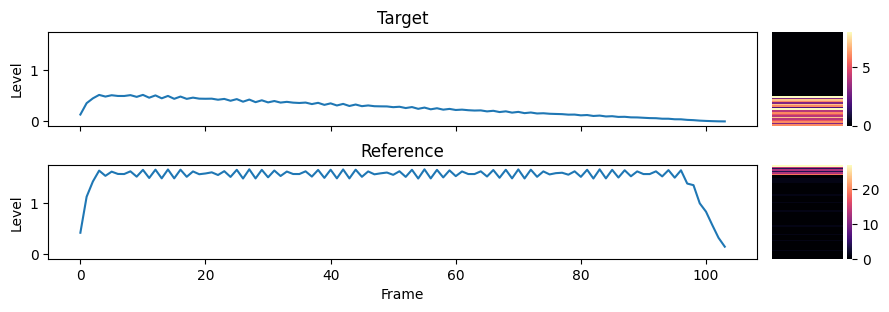

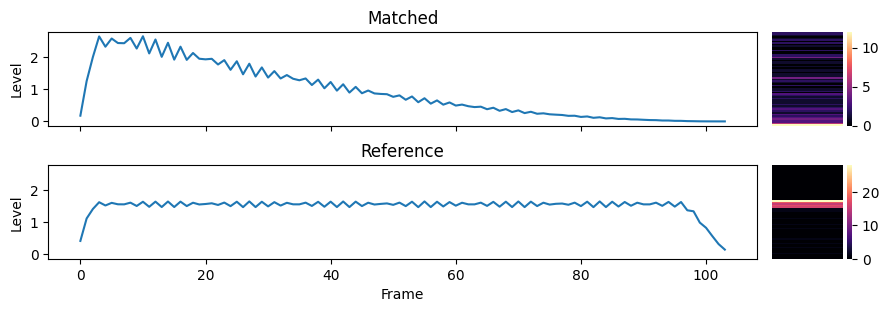

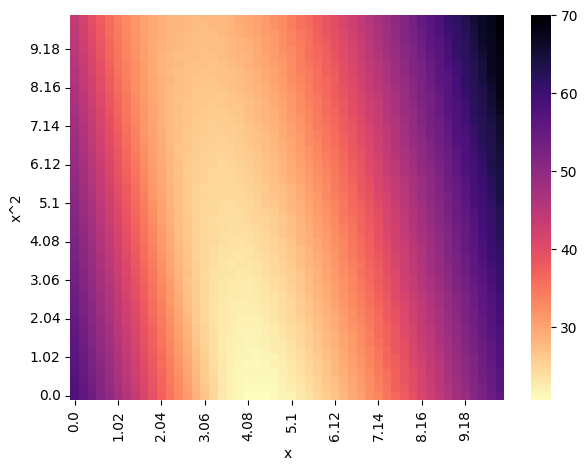

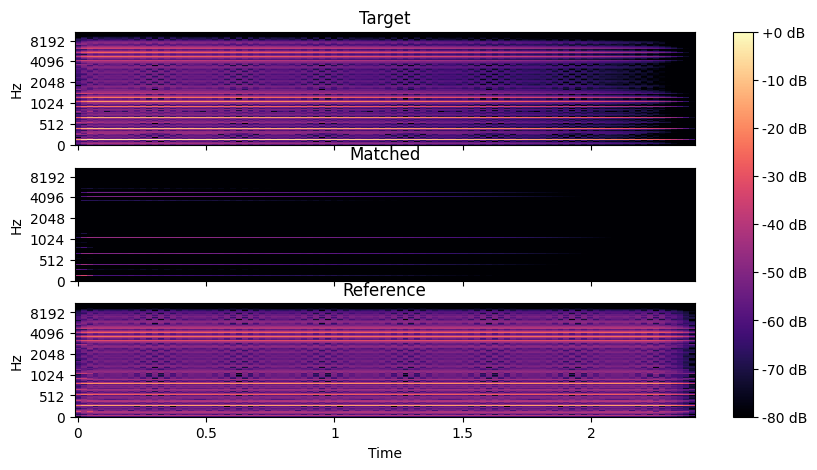

In [68]:
tAudio, rAudio = importAudio(target="tonequiet.wav",reference="toneloud.wav", output=False)
#tAudio, rAudio = importAudio(target="audio_mono.wav",reference="audio2_mono.wav", output=True)

mAudio = dynamicMatching(tAudio,rAudio,dynamicBins=64, plotBin=100, tempscaler=[0,10])
bruteForceMatching(tAudio,rAudio,dynamicBins=64, freqBin=100, testDistance=10, steps=50)

#mAudio = EQMatching(tAudio,rAudio,smoothing=1, plot=True)

plotSpectrogram(tAudio, mAudio, rAudio)

In [17]:
testArr = np.array([1,2,3,4,5])
0.2*testArr**2 + 0.2*testArr

array([0.4, 1.2, 2.4, 4. , 6. ])

In [18]:
exportAudio(tAudio, mAudio, rAudio)

Target


Matched


Reference


In [5]:
x = np.array([1, 2, 3, 4, 5])
f = lambda x: x ** 2
squares = f(x)
squares

array([ 1,  4,  9, 16, 25])

In [72]:
test = rAudio["STFT"][100,:][2]
test

(-0.35617718+1.3712624j)

In [85]:
pre = np.abs(test)
(pre ** 2) + (pre ** 4)

6.036167137814631

In [69]:
post = (test ** 2) + (test ** 4)
np.abs(post)

2.4762545996634646

In [89]:
fix = (test * np.abs(test)) + (test * np.abs(test) * np.abs(test) * np.abs(test) )
np.abs(fix)

6.036167